In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import concurrent.futures

# Setup the TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load the pretrained ResNet50 model without the top classification layer
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224 for ResNet50
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adding the batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image
    features = model.predict(img_array, verbose=0)  # Suppress progress bar
    return features.flatten()  # Flatten the feature map to a 1D vector

def compute_similarity_score(base_image_path, image_list):
    base_image_features = extract_features(base_image_path)
    similarities = {}

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(extract_features, img_path): img_path for img_path in image_list}
        for future in concurrent.futures.as_completed(futures):
            img_path = futures[future]
            img_features = future.result()
            score = cosine_similarity([base_image_features], [img_features])[0][0]
            similarities[img_path] = score

    return similarities

# The image example
base_image_path = '0016F5FCE9776814847991ACFF81855AFE7C3F79202B3424DEE09B2997F748E4.png'
# Your directory where you have all your images
image_directory = 'Combined5'

# Get a list of images to compare
image_list = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith(('png'))]

# Limit the number of images. I did make it 3000 
subset_size = 3000  # Adjust it if it fail
image_list = image_list[:subset_size]

# Calculate the similarity score
similarity_scores = compute_similarity_score(base_image_path, image_list)

# Sort images by similarity score (highest to lowest)
sorted_similarity = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)

# Display all the results. File and score. 
for img_path, score in sorted_similarity:
    print(f"Image: {img_path}, Similarity Score: {score}")


Image: Combined5/66EEF92481D29693DB3294995738E09EB0F6825C3D1A0D588F2D05A56A398399.png, Similarity Score: 0.9789919257164001
Image: Combined5/9740F33C0BFA3C92F441EDCC4019802CA7A83910FF5A4BA96B00F613D2AFB626.png, Similarity Score: 0.9789795875549316
Image: Combined5/3755D3C82FBC950A882CB2E546DAE96594441D4497994BF61672A6C26AEEFD0E.png, Similarity Score: 0.9781560897827148
Image: Combined5/39C1B35FB4EB69EA50A74DA12E52A77ED488F98DAEE899E1FF33A205D018E95A.png, Similarity Score: 0.9766674041748047
Image: Combined5/6E0FAA4875F0A813F3CBEC492B3DB2D1CB6BA964120CFF44355FD36301F368F3.png, Similarity Score: 0.9765453338623047
Image: Combined5/B8B1BBB0BD6BE4B2A1A4B427E1B9BADB6EC9ECE7F24671EE25E51C1F2EF3F75C.png, Similarity Score: 0.9763978719711304
Image: Combined5/5D804F71C0CF0CA14FA43C37AC1867A76F257F54B7815CCB3CE5545838D550D2.png, Similarity Score: 0.9757466316223145
Image: Combined5/AE7A14F228DC7350B4115BE927EA1E6F7569E308F044C3860A3BDBD52135C185.png, Similarity Score: 0.975562572479248
Image: Co

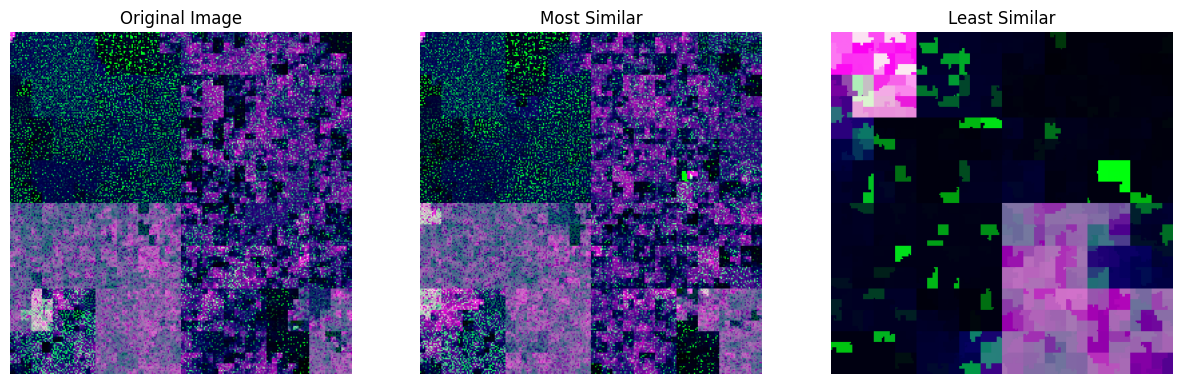

In [16]:
# This just to display the high similar images
most_similar_image = max(similarity_scores, key=similarity_scores.get)
least_similar_image = min(similarity_scores, key=similarity_scores.get)

# Load the images
image_paths = [base_image_path, most_similar_image, least_similar_image]
labels = ["Original Image", "Most Similar", "Least Similar"]

# Load the images
images = [mpimg.imread(img_path) for img_path in image_paths]

# Create a figure and display the images side by side with labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(labels[i])  # Add a title 
    ax.axis('off')  # Turn off axis labels

plt.show()


Top 5 most similar images:
Image: Combined5/F88180A82667B51732370EAC6BEA52D95F9B2253B90D2A5C2D7730138D547F79.png, Similarity Score: 0.5237416177964017
Image: Combined5/4D15FEDBFCAA8E4D0026790295F2F87251D0A9A3FC7F03C856EC8F427ED45816.png, Similarity Score: 0.5172660947598664
Image: Combined5/B6A1996AA4FE3A05FBE32DF034055355C089AF7398D71EBBBBC5225355A6F758.png, Similarity Score: 0.5161755663468652
Image: Combined5/38F04CD56AECB0DF71DDCB31779E35E275EA7D5DB6624DE87C9BA008B65E8036.png, Similarity Score: 0.5137944295040398
Image: Combined5/0A80F90C61684AD6A2FC17EDDFBB5D84B34273E50D56F8BFC4F0CE9CDE145C9D.png, Similarity Score: 0.5134612479561499

Top 5 least similar images:
Image: Combined5/86E3B42151DDACD1A723BBB9C5D3CD4DF4E1D95B4CA88ABD6D6D24B12F391769.png, Similarity Score: 0.2529650599228301
Image: Combined5/19AA08DE4D5958FB30A9114F01DC29708A0BFBC84C27314D659102DB47AA6464.png, Similarity Score: 0.2513319210441133
Image: Combined5/98981D400DE9C70997CA0520C9E88F993AD2F1AAF01F6D4DF3A2EC4A8F7

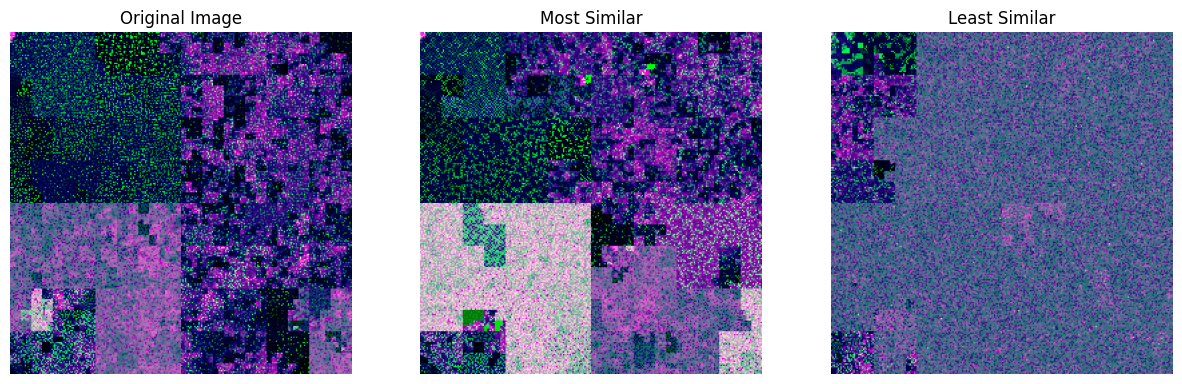

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import mutual_info_score

# Path to the original image
base_image_path = '0016F5FCE9776814847991ACFF81855AFE7C3F79202B3424DEE09B2997F748E4.png'

# Directory of images to compare (subset of 3000 images)
image_directory = 'Combined5'
subset_size = 30000

# Get a list of images to compare
image_list = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith(('png'))][:subset_size]

def compute_mutual_information(img1_path, img2_path, n_bins=256):
    # Read images and convert to grayscale
    img1 = rgb2gray(imread(img1_path))
    img2 = rgb2gray(imread(img2_path))
    
    # Flatten the images into 1D arrays
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    
    # Discretize pixel values into bins
    img1_binned = np.digitize(img1_flat, bins=np.linspace(0, 1, n_bins))
    img2_binned = np.digitize(img2_flat, bins=np.linspace(0, 1, n_bins))
    
    # Compute mutual information score on discretized data
    mi_score = mutual_info_score(img1_binned, img2_binned)
    return mi_score

def compute_similarity_scores(base_image_path, image_list):
    similarities = {}
    for img_path in image_list:
        try:
            score = compute_mutual_information(base_image_path, img_path)
            similarities[img_path] = score
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return similarities

# Compute mutual information similarity scores
similarity_scores = compute_similarity_scores(base_image_path, image_list)

# Sort images by similarity score (highest to lowest)
sorted_similarity = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)

# Display the top 5 most similar and least similar images to you image
top_5 = sorted_similarity[:5]
bottom_5 = sorted_similarity[-5:]

# Show the results
print("Top 5 most similar images:")
for img_path, score in top_5:
    print(f"Image: {img_path}, Similarity Score: {score}")

print("\nTop 5 least similar images:")
for img_path, score in bottom_5:
    print(f"Image: {img_path}, Similarity Score: {score}")

# Display (Original, Most Similar, Least Similar)
def display_images(original_img_path, most_similar_img_path, least_similar_img_path):
    images = [original_img_path, most_similar_img_path, least_similar_img_path]
    labels = ["Original Image", "Most Similar", "Least Similar"]
    
    # Load and display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        img = imread(images[i])
        ax.imshow(img)
        ax.set_title(labels[i])
        ax.axis('off')
    
    plt.show()

# Show the original, most similar, and least similar images
display_images(base_image_path, top_5[0][0], bottom_5[0][0])


### Graph these using t-SNE 

### Graph these using UMAP approach